# LArTPC Detector Data Clustering Analysis

Clustering algorithm development. Testing different ideas. This notebook processes raw LArIAT LArTPC detector data to identify and analyse particle tracks through clustering algorithms.

## What This Notebook Does

1. **Loads Raw Detector Data**: Reads ROOT files containing ADC (charge) measurements from 480 detector wires
2. **Separates Wire Planes**: Organizes data into:
   - **Induction Plane** (wires 0-239): First detection layer
   - **Collection Plane** (wires 240-479): Final detection layer  
3. **Creates Event Displays**: Generates 2D heatmaps showing particle tracks as they deposit energy
4. **Finds Particle Clusters**: Uses image processing to identify connected regions of detector hits
5. **Analyzes Track Properties**: Extracts start points, peak signals, and track characteristics

## Key Variables

- `collection.T` / `induction.T`: 2D matrices [time_ticks × wires] containing ADC values
- `col_props` / `ind_props`: List of detected particle track regions with properties
- `threshold`: Minimum ADC value to consider as a real signal (typically 30-120)

## Main Functions

- `find_largest_cluster()`: Finds the biggest particle track in the event
- `find_cluster_by_adc_ratio()`: Finds tracks with the highest signal variation (good for protons due to their Bragg Peak)
- `get_first_wire_max_adc()`: Locates track starting point coordinates
- `visualize_clusters_basic()`: Shows detector images with identified tracks highlighted


Mainly single-track proton events.

Uses RAW data from LArIAT and data created in **onetrack.ipynb**

In [2]:
import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ONE_TRACK_PROTONS = "/Users/user/data/research/proton-deuteron/csv/selectedprotons_onetrack_eventdisplay.csv"
RAW_FILES = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root"

# Some RAW PROTON data files
RAW0 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0002_20160529T072344_evtsel_1.root"
RAW1 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0004_20160529T072435_evtsel_1.root"
RAW2 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root"
RAW3 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008562_sr0146_20160530T075212_evtsel_1.root"

In [4]:
# Open file
file = uproot.open(RAW0)
file.keys(), file.classnames()

(['ana;1', 'ana/raw;1'], {'ana;1': 'TDirectory', 'ana/raw;1': 'TTree'})

In [5]:
# Open tree
tree = file["ana/raw"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
subrun               | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
evttime              | double                   | AsDtype('>f8')
efield               | float                    | AsDtype('>f4')
lifetime             | float                    | AsDtype('>f4')
t0                   | int32_t                  | AsDtype('>i4')
raw_samples          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
raw_pedestal         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_sigma            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_rawadc           | std::vector<int16_t>     | AsJagged(AsDtype('>i2'), he...
raw_channel          | std::vector<uint32_t>    | AsJagged(

In [6]:
# Looking at data in the file
data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
data, len(data)

(<Array [{raw_rawadc: [...], ...}, {...}] type='2 * {raw_rawadc: var * int16...'>,
 2)

In [7]:
# Putting data into NumPy arrays

adc_data = ak.to_numpy(data[0]["raw_rawadc"])
channel_map = ak.to_numpy(data[0]["raw_channel"])
adc_data, channel_map, adc_data.shape, channel_map.shape

(array([-2, -2, -2, ..., -1, -1, -1], dtype=int16),
 array([335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323,
        322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310,
        309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297,
        296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284,
        283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272,  47,
         46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
         33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
         20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
          7,   6,   5,   4,   3,   2,   1,   0, 479, 478, 477, 476, 475,
        474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 175, 174,
        173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161,
        160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148,
        147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135,

In [8]:
# Getting number of wires and number of ticks (the event display coordinates)

num_channels_in_event = len(channel_map) # 480 - 240 in collection, 240 in induction - number of wires
num_ticks = len(adc_data) // num_channels_in_event # 480 wires, record a sample 3072 times. 
num_channels_in_event, num_ticks

(480, 3072)

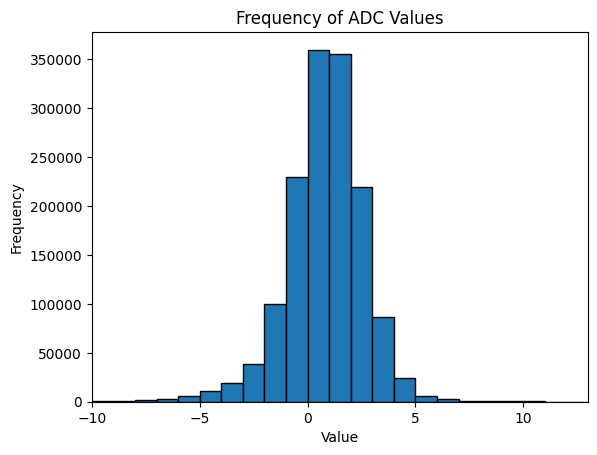

In [9]:
# Plotting histogram to understand what background ADC values look like.

plt.hist(adc_data, bins='auto', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of ADC Values')
plt.xlim(-10, 13)
# plt.ylim(0, 100)
plt.show()

# Most are obviously around 0 - helps put a threshold.

In [10]:
# Turning flat ADC array into 2D array. Each 3072 values are one wire, over 3072 time ticks. Wire are not ordered, but their index is given in channel_map.

adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks)) # wire numbers not ordered, every 3072 is one channel
adc_data2d

array([[-2, -2, -2, ..., -2, -1, -2],
       [ 1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  2, ...,  3,  3,  3],
       ...,
       [-1, -2, -1, ...,  2,  2,  2],
       [ 3,  2,  3, ...,  3,  2,  2],
       [ 1,  2,  1, ..., -1, -1, -1]], dtype=int16)

In [11]:
# Initialising arrays for the two wire planes

collection = np.zeros((240, num_ticks))
induction = np.zeros((240, num_ticks))

In [12]:
# Organising the wires properly and data input into collection and induction. 

for i, channel_num in enumerate(channel_map):
    if 0 <= channel_num < 240:
        wire_index = channel_num
        induction[wire_index, :] = adc_data2d[i, :] # each row is a channel/wire, going 0 -> 239 (ordered) we have 240 rows, each with 3072 columns (time)
    if 240 <= channel_num < 480:
        wire_index = channel_num - 240
        collection[wire_index, :] = adc_data2d[i, :]  # each row is a channel/wire, going 240 -> 479 (orded)

In [13]:
# Final arrays 

induction, collection

(array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
        [ 2.,  2.,  2., ...,  1.,  1.,  1.],
        [ 2.,  2.,  1., ...,  1.,  1.,  0.],
        ...,
        [-1., -1., -1., ...,  0.,  0.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[ 1.,  2.,  1., ..., -1., -1., -1.],
        [ 3.,  2.,  3., ...,  3.,  2.,  2.],
        [-1., -2., -1., ...,  2.,  2.,  2.],
        ...,
        [ 0.,  0.,  0., ..., -1., -1., -1.],
        [ 1.,  2.,  2., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  2.,  1.,  1.]]))

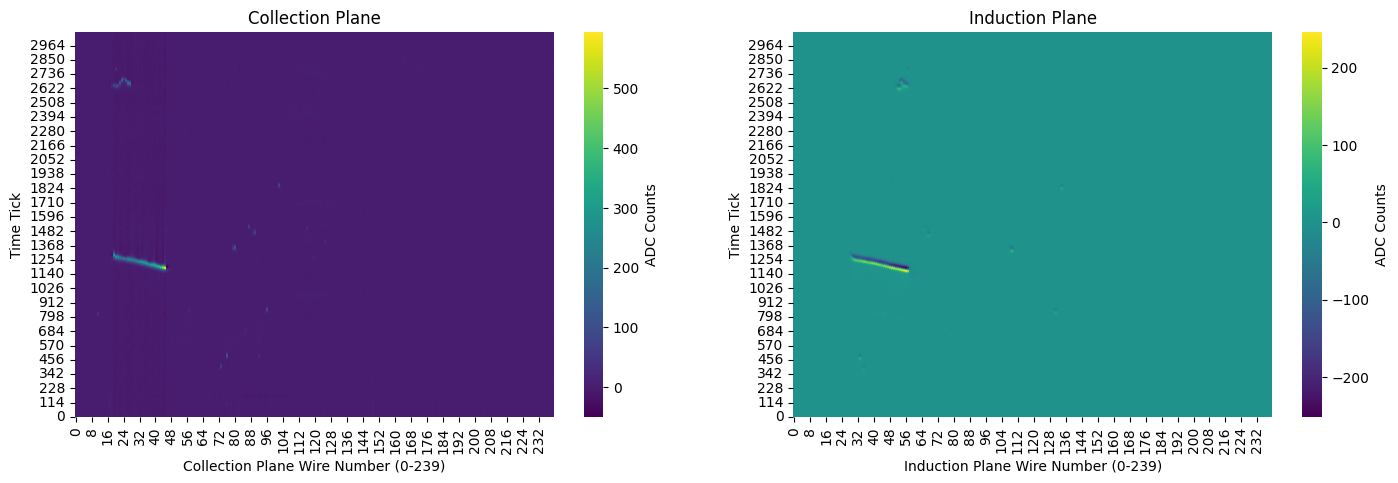

In [14]:
# Event displays

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))


sns.heatmap(collection.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title("Collection Plane")
ax1.invert_yaxis()

sns.heatmap(induction.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# Finding clusters through a simple threshold.

## HOW THIS WORKS:
Create a binary mask using a simple threshold for the ADC value (e.g. 50). So you get a 240 x 3072 matrix, where every value below 50 gets turned into a 0, and above 50 gets turned into a 1. 

Then we input this matrix to find connected regions. Two pixels (elements in the matrix) are connected if they have the same value (here 1's together will be connected, 0's are disregarded). skimage's label then returns a matrix with 0's being background, and each cluster having values 1, 2, 3, 4 (therefore, pixels in cluster 1, will all have value 1, in cluster two, will have value 2, and so on.)  

This labelled matrix matrix is then input into 'regionprops' that gives the properties of the region, such as the bounding box, area, etc. and also takes the original ADCs into consideration to calculate min, max intensity, etc. 

In [15]:
# Finding clusters through a simple threshold.

from skimage.measure import label, regionprops

def find_connected_regions(matrix, threshold=10):
    """Find connected regions of signal above threshold"""
    # Create binary mask (matrix 240 x 3072) of significant signals.
    # (True (1) for above threshold, False (0) for below threshold.)
    binary_mask = matrix > threshold
    
    # Label connected pixels
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    # Properties of each region
    regions = regionprops(labeled_regions, intensity_image=matrix) # arg "intensity_image" re-introduces the ADC values, now that clusters are identified. 
    
    for i, region in enumerate(regions):
        print(f"Region {i+1}:")
        print(f"  Area: {region.area} pixels")
        print(f"  Max intensity: {region.intensity_max:.1f}")
        
        # Total intensity using the original matrix and region coordinates
        total_intensity = matrix[region.coords[:, 0], region.coords[:, 1]].sum()
        print(f"  Total intensity: {total_intensity:.1f}")
    
    return labeled_regions, regions

# Applying to both planes
print("Collection Plane Clustering:")
col_regions, col_props = find_connected_regions(collection.T, threshold=50)

print("\nInduction Plane Clustering:")
ind_regions, ind_props = find_connected_regions(induction.T, threshold=25)

Collection Plane Clustering:
Found 9 connected regions
Region 1:
  Area: 21.0 pixels
  Max intensity: 75.0
  Total intensity: 1391.0
Region 2:
  Area: 33.0 pixels
  Max intensity: 137.0
  Total intensity: 3363.0
Region 3:
  Area: 27.0 pixels
  Max intensity: 109.0
  Total intensity: 2348.0
Region 4:
  Area: 1389.0 pixels
  Max intensity: 594.0
  Total intensity: 249175.0
Region 5:
  Area: 43.0 pixels
  Max intensity: 119.0
  Total intensity: 3606.0
Region 6:
  Area: 24.0 pixels
  Max intensity: 80.0
  Total intensity: 1658.0
Region 7:
  Area: 16.0 pixels
  Max intensity: 63.0
  Total intensity: 937.0
Region 8:
  Area: 24.0 pixels
  Max intensity: 87.0
  Total intensity: 1753.0
Region 9:
  Area: 257.0 pixels
  Max intensity: 188.0
  Total intensity: 25185.0

Induction Plane Clustering:
Found 9 connected regions
Region 1:
  Area: 7.0 pixels
  Max intensity: 28.0
  Total intensity: 190.0
Region 2:
  Area: 24.0 pixels
  Max intensity: 61.0
  Total intensity: 1140.0
Region 3:
  Area: 17.0 p

In [16]:
# visualising clusters

import matplotlib.patches as patches

def visualize_clusters_basic(matrix, labeled_regions, regions, plane_name):
    """Basic visualization of clusters overlaid on detector image"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original heatmap
    sns.heatmap(matrix, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC Counts'})
    ax1.set_title(f"{plane_name} - Original")
    ax1.set_xlabel("Wire Number")
    ax1.set_ylabel("Time Tick")
    ax1.invert_yaxis()
    
    # Clusters overlay
    sns.heatmap(matrix, cmap="viridis", ax=ax2, alpha=0.9, cbar_kws={'label': 'ADC Counts'})
    
    # Cluster boundaries
    colors = plt.cm.Set1(np.linspace(0, 1, len(regions)))
    
    for i, (region, color) in enumerate(zip(regions, colors)):
        # Bounding box
        minr, minc, maxr, maxc = region.bbox
        
        # Rectangle around cluster
        rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                               linewidth=0.5, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)
        
        # Cluster label
        ax2.text(minc-15, minr-10, f'C{i+1}', color=color, fontweight='bold', fontsize=12)
    
    ax2.set_title(f"{plane_name} - Clusters")
    ax2.set_xlabel("Wire Number")
    ax2.set_ylabel("Time Tick")
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def visualize_clusters_highlight(matrix, labeled_regions, regions, plane_name):
    """Basic visualization of clusters overlaid on detector image"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original heatmap
    sns.heatmap(matrix, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC Counts'})
    ax1.set_title(f"{plane_name} - Original")
    ax1.set_xlabel("Wire Number")
    ax1.set_ylabel("Time Tick")
    ax1.invert_yaxis()
    
    # Clusters overlay
    sns.heatmap(matrix, cmap="viridis", ax=ax2, alpha=0.7, cbar_kws={'label': 'ADC Counts'})
    
    # Highlight cluster pixels
    colors = plt.cm.Set1(np.linspace(0, 1, len(regions)))
    
    for i, (region, color) in enumerate(zip(regions, colors)):
        # Get all pixel coordinates in the cluster
        coords = region.coords
        
        # Scatter plot to highlight cluster pixels
        ax2.scatter(coords[:, 1], coords[:, 0], color=color, s=0.2, alpha=0.8, label=f'Active')
        
        # Optional: Add bounding box
        minr, minc, maxr, maxc = region.bbox
        rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                               linewidth=1, edgecolor=color, facecolor='none',
                               linestyle='--', alpha=0.8)
        ax2.add_patch(rect)
    
    ax2.set_title(f"{plane_name} - Clusters Highlighted")
    ax2.set_xlabel("Wire Number")
    ax2.set_ylabel("Time Tick")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

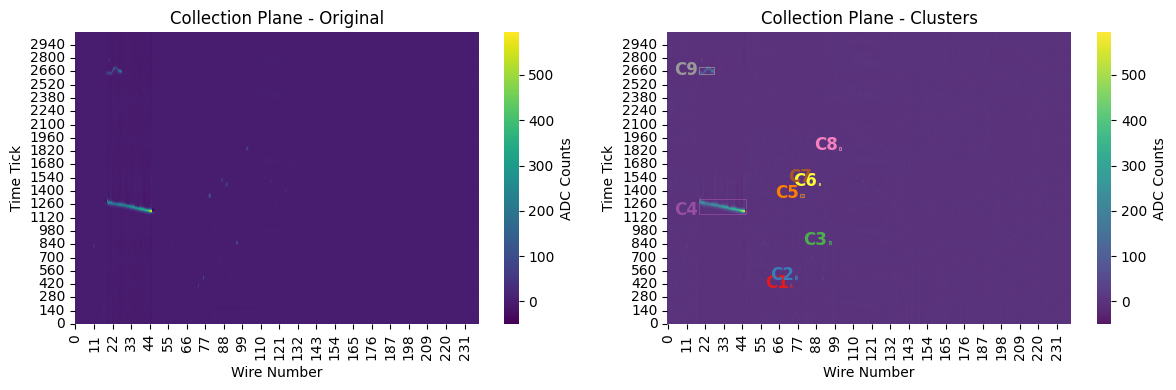

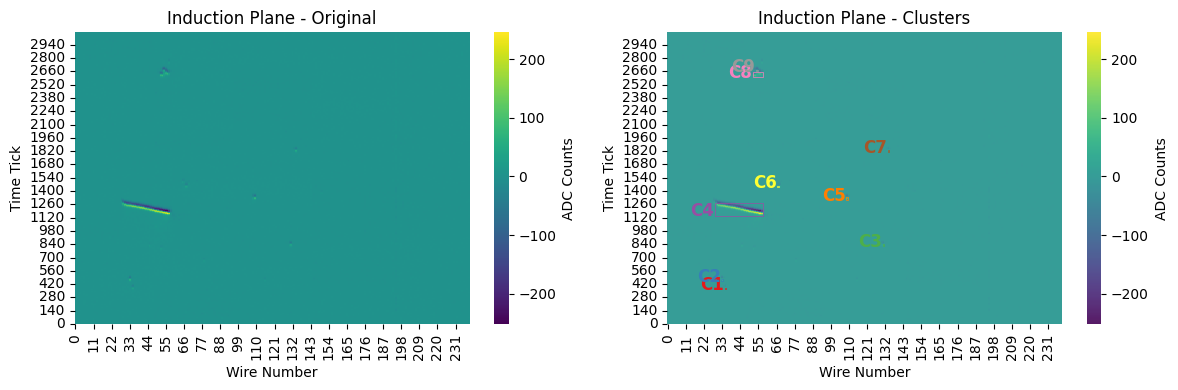

In [17]:
# Both planes
if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")

Want only one cluster - the one with the proton, others are irrelevant. Maybe good to select a threshold for region area (cluster size)? This will remove small products from inelastic scaterring, stuff happening due to neutrons. 

However, if muons are involved, this might prioritise them over shorter protons. 

In [18]:
def find_largest_cluster(matrix, threshold=10):
    """Find only the largest connected region above threshold"""
    binary_mask = matrix > threshold
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    if num_regions == 0:
        return None, None

    regions = regionprops(labeled_regions, intensity_image=matrix)
    
    # The largest region by area
    largest_region = max(regions, key=lambda r: r.area)
    largest_idx = regions.index(largest_region)
    
    print(f"Largest Region:")
    print(f"  Area: {largest_region.area} pixels")
    print(f"  Centroid: ({largest_region.centroid[0]:.1f}, {largest_region.centroid[1]:.1f})")
    print(f"  Max intensity: {largest_region.intensity_max:.1f}")

    total_intensity = matrix[largest_region.coords[:, 0], largest_region.coords[:, 1]].sum()
    print(f"  Total intensity: {total_intensity:.1f}")
    
    # New labeled image with only the largest region
    single_cluster_mask = labeled_regions == (largest_idx + 1)
    
    return single_cluster_mask.astype(int), [largest_region]

# Single cluster only
print("Collection Plane - Largest Cluster:")
col_regions, col_props = find_largest_cluster(collection.T, threshold=50)

print("\nInduction Plane - Largest Cluster:")
ind_regions, ind_props = find_largest_cluster(induction.T, threshold=25)

Collection Plane - Largest Cluster:
Found 9 connected regions
Largest Region:
  Area: 1389.0 pixels
  Centroid: (1234.8, 32.3)
  Max intensity: 594.0
  Total intensity: 249175.0

Induction Plane - Largest Cluster:
Found 9 connected regions
Largest Region:
  Area: 916.0 pixels
  Centroid: (1207.1, 43.2)
  Max intensity: 246.0
  Total intensity: 92148.0


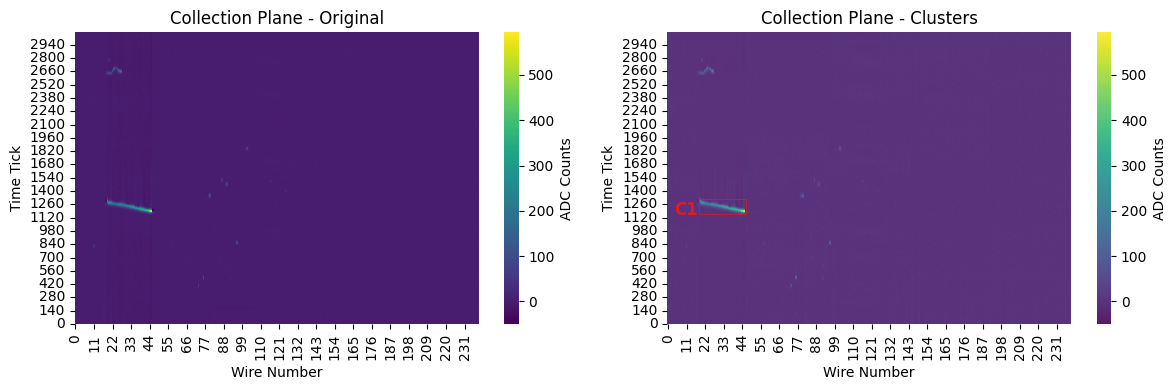

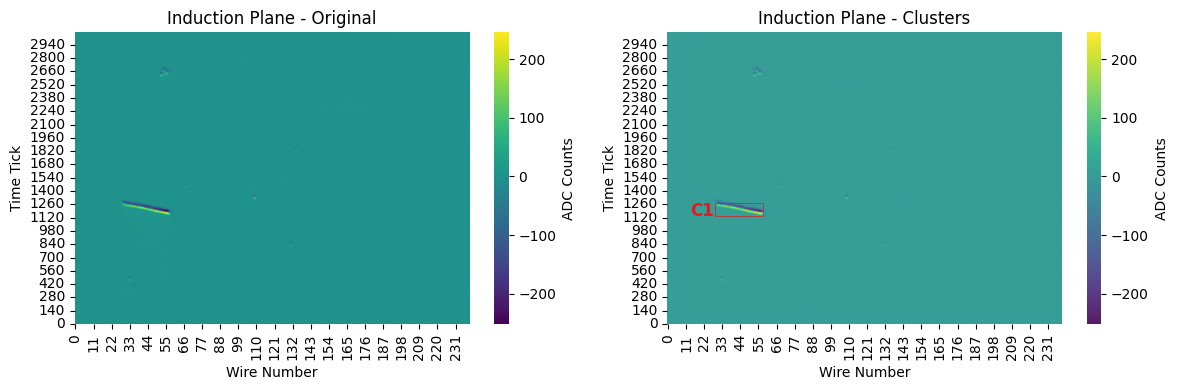

In [19]:
# Visualising

if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")


Or by ratio of min-max ADC. This would take advantage of Bragg peak characteristic of proton tracks. Might work better with events with muons. 

In [20]:
def find_cluster_by_adc_ratio(matrix, threshold=10):
    """Find cluster with the largest max/min ADC ratio"""

    binary_mask = matrix > threshold
    
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    if num_regions == 0:
        return None, None
    
    regions = regionprops(labeled_regions, intensity_image=matrix)
    
    # Calculate ADC ratio for each region
    adc_ratios = []
    for region in regions:
        region_values = matrix[region.coords[:, 0], region.coords[:, 1]] # getting ADC values of pixels in region.
        min_adc = region_values.min() 
        max_adc = region_values.max()
        
        # Avoid division by zero
        if min_adc > 0:
            adc_ratio = max_adc / min_adc
        else:
            adc_ratio = max_adc / (min_adc + 1e-6)  # Add small epsilon
        
        adc_ratios.append(adc_ratio)
    
    # Region with largest ADC ratio
    max_ratio_idx = np.argmax(adc_ratios)
    selected_region = regions[max_ratio_idx]
    
    # ADC statistics for selected region
    region_values = matrix[selected_region.coords[:, 0], selected_region.coords[:, 1]]
    min_adc = region_values.min()
    max_adc = region_values.max()
    adc_ratio = adc_ratios[max_ratio_idx]
    
    print(f"Region with largest ADC ratio:")
    print(f"  Min ADC: {min_adc:.1f}")
    print(f"  Max ADC: {max_adc:.1f}")
    print(f"  ADC Ratio (max/min): {adc_ratio:.2f}")
    print(f"  Area: {selected_region.area} pixels")
    print(f"  Centroid: ({selected_region.centroid[0]:.1f}, {selected_region.centroid[1]:.1f})")
    
    # Labeled image with only the selected region
    single_cluster_mask = labeled_regions == (max_ratio_idx + 1)
    
    return single_cluster_mask.astype(int), [selected_region]

print("Collection Plane - Largest ADC Ratio:")
col_regions, col_props = find_cluster_by_adc_ratio(collection.T, threshold=120)

print("\nInduction Plane - Largest ADC Ratio:")
ind_regions, ind_props = find_cluster_by_adc_ratio(induction.T, threshold=30)

Collection Plane - Largest ADC Ratio:
Found 5 connected regions
Region with largest ADC ratio:
  Min ADC: 121.0
  Max ADC: 594.0
  ADC Ratio (max/min): 4.91
  Area: 913.0 pixels
  Centroid: (1233.8, 32.9)

Induction Plane - Largest ADC Ratio:
Found 8 connected regions
Region with largest ADC ratio:
  Min ADC: 31.0
  Max ADC: 246.0
  ADC Ratio (max/min): 7.94
  Area: 873.0 pixels
  Centroid: (1207.5, 43.3)


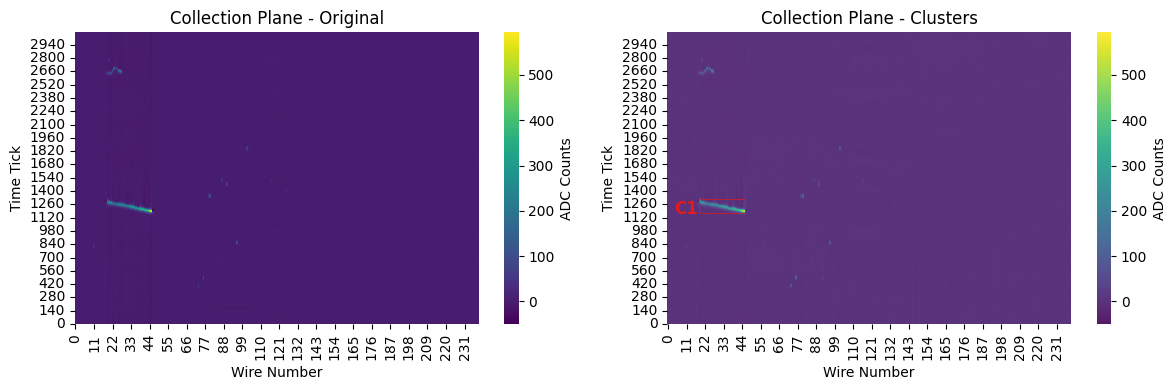

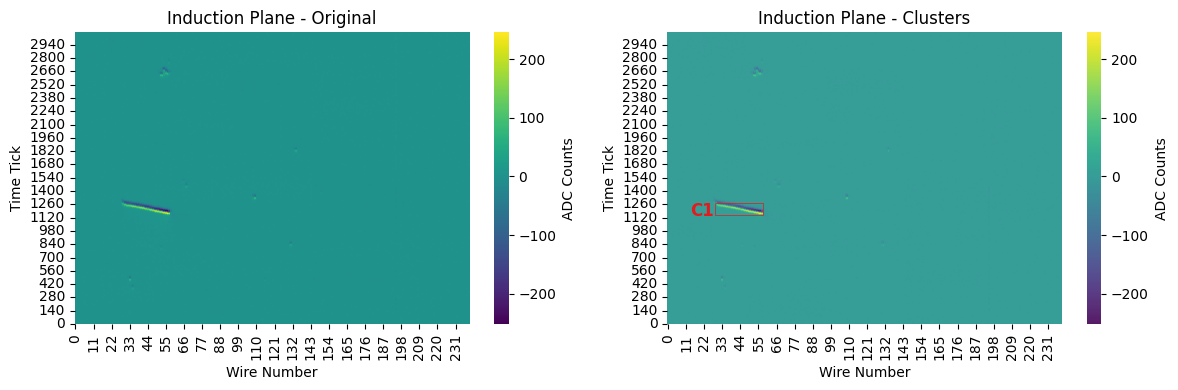

In [21]:
# Visualising

if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")


Combine the two? How to improve for muons - better thresholding, checking for sudden dips if muon + proton event? 

How to find first point coordinate? Need this for deuteron search from the deuteron candidates.

Solution 1: Taking first wire, then find the time tick with the highest ADC.

In [22]:
def get_first_wire_max_adc(region, matrix):
    """Find first wire in region, then get time tick with highest ADC on that wire"""
    
    # Bounding box to find first (minimum) wire
    min_time, min_wire, max_time, max_wire = region.bbox
    
    print(f"First wire in region: {min_wire}")
    
    # All pixels in the cluster on the first wire
    coords = region.coords
    first_wire_pixels = coords[coords[:, 1] == min_wire]  # coords[:, 1] is wire column
    
    if len(first_wire_pixels) == 0:
        print(f"No pixels found on first wire {min_wire} (this shouldn't happen)")
        return None, None, None
    
    # ADC values for all pixels on the first wire
    first_wire_times = first_wire_pixels[:, 0]  # coords[:, 0] is time column
    first_wire_adcs = matrix[first_wire_times, min_wire]
    
    # The time tick with maximum ADC on this wire
    max_adc_idx = np.argmax(first_wire_adcs)
    max_adc_time = first_wire_times[max_adc_idx]
    max_adc_value = first_wire_adcs[max_adc_idx]
    
    print(f"On first wire {min_wire}:")
    print(f"  Max ADC value: {max_adc_value:.1f}")
    print(f"  Coordinate: (wire={min_wire}, time={max_adc_time})")
    
    return min_wire, max_adc_time, max_adc_value

# Apply to existing clusters
if col_props and len(col_props) > 0:
    print("Collection Plane - First wire max ADC:")
    col_wire, col_time, col_adc = get_first_wire_max_adc(col_props[0], collection.T)
    
if ind_props and len(ind_props) > 0:
    print("\nInduction Plane - First wire max ADC:")
    ind_wire, ind_time, ind_adc = get_first_wire_max_adc(ind_props[0], induction.T)

Collection Plane - First wire max ADC:
First wire in region: 19
On first wire 19:
  Max ADC value: 267.0
  Coordinate: (wire=19, time=1291)

Induction Plane - First wire max ADC:
First wire in region: 29
On first wire 29:
  Max ADC value: 63.0
  Coordinate: (wire=29, time=1264)


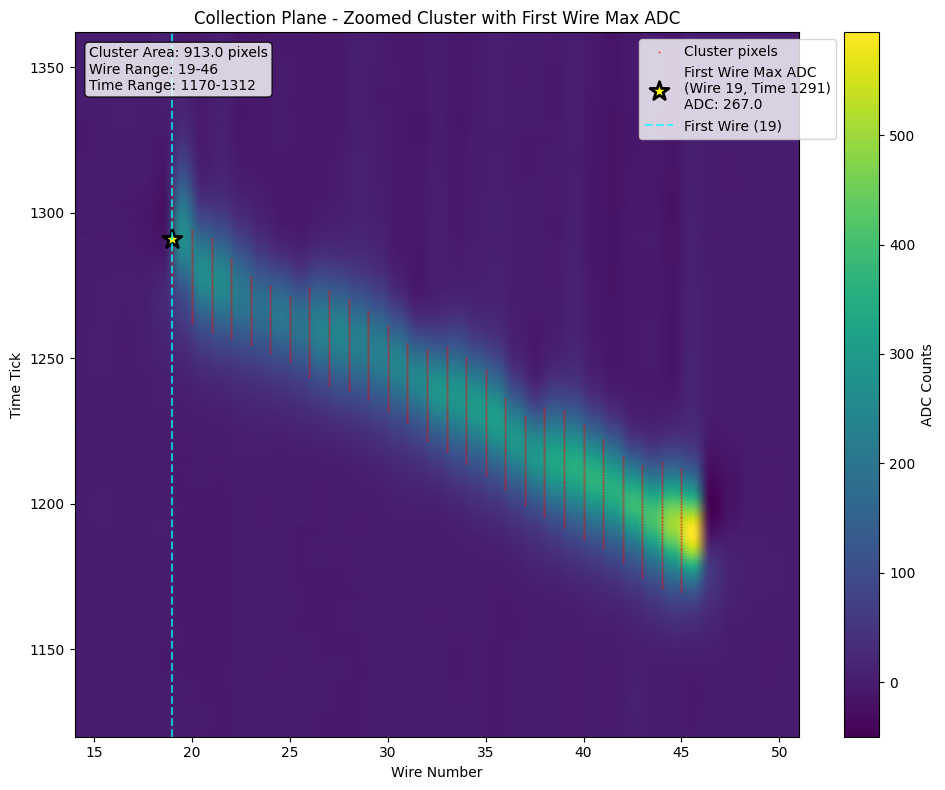

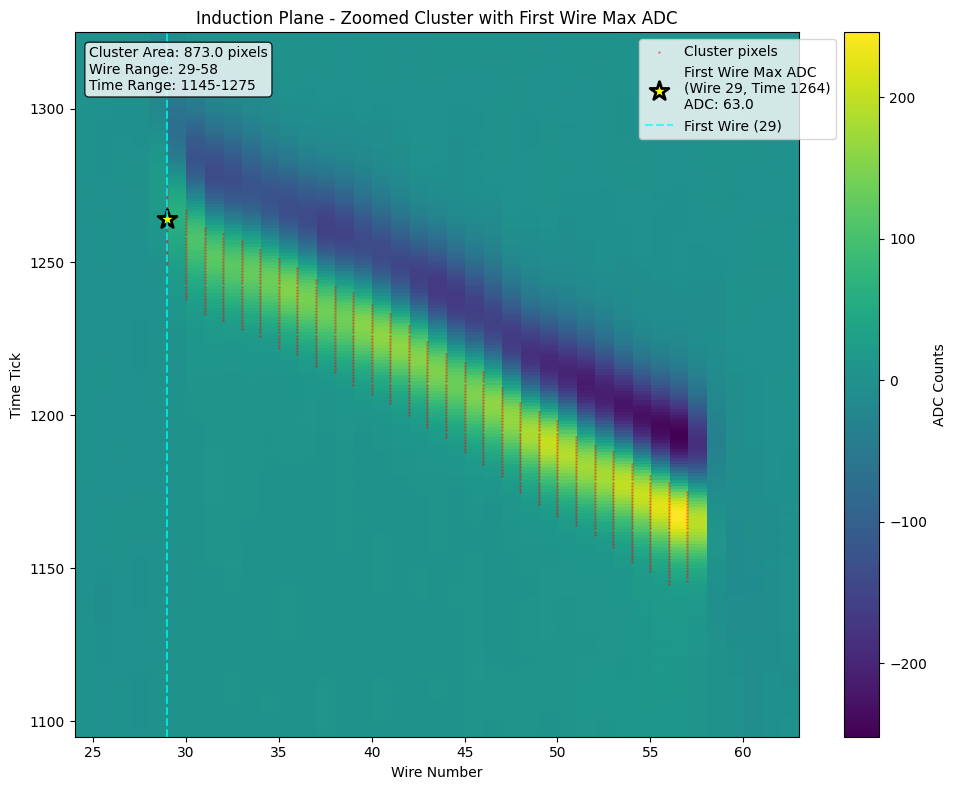

In [23]:
def plot_first_wire_coordinate(region, matrix, plane_name, first_wire_coord=None):
    """Plot event display zoomed to cluster with first wire max ADC coordinate marked"""
    
    # Cluster bounding box for zooming
    min_time, min_wire, max_time, max_wire = region.bbox
    
    # Padding around the cluster
    padding_time = max(50, int((max_time - min_time) * 0.1))
    padding_wire = max(5, int((max_wire - min_wire) * 0.1))
    
    zoom_min_time = max(0, min_time - padding_time)
    zoom_max_time = min(matrix.shape[0], max_time + padding_time)
    zoom_min_wire = max(0, min_wire - padding_wire)
    zoom_max_wire = min(matrix.shape[1], max_wire + padding_wire)
    
    # Coomed region
    zoomed_matrix = matrix[zoom_min_time:zoom_max_time, zoom_min_wire:zoom_max_wire]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    im = ax.imshow(zoomed_matrix, cmap='viridis', aspect='auto', 
                   extent=[zoom_min_wire, zoom_max_wire, zoom_max_time, zoom_min_time])
    
    plt.colorbar(im, ax=ax, label='ADC Counts')
    
    # Marking the cluster boundary
    cluster_coords = region.coords
    cluster_in_zoom = cluster_coords[
        (cluster_coords[:, 0] >= zoom_min_time) & (cluster_coords[:, 0] < zoom_max_time) &
        (cluster_coords[:, 1] >= zoom_min_wire) & (cluster_coords[:, 1] < zoom_max_wire)
    ]
    
    if len(cluster_in_zoom) > 0:
        ax.scatter(cluster_in_zoom[:, 1], cluster_in_zoom[:, 0], 
                  c='red', s=1, alpha=0.3, label='Cluster pixels')
    
    # Mark the first wire max ADC coordinate
    if first_wire_coord is not None:
        wire, time, adc = first_wire_coord
        if (zoom_min_wire <= wire < zoom_max_wire and 
            zoom_min_time <= time < zoom_max_time):
            ax.scatter(wire, time, c='yellow', s=200, marker='*', 
                      edgecolors='black', linewidth=2, 
                      label=f'First Wire Max ADC\n(Wire {wire}, Time {time})\nADC: {adc:.1f}')
    
    # Mark first wire line
    if zoom_min_wire <= min_wire < zoom_max_wire:
        ax.axvline(x=min_wire, color='cyan', linestyle='--', alpha=0.7, 
                   label=f'First Wire ({min_wire})')
    
    ax.set_xlabel('Wire Number')
    ax.set_ylabel('Time Tick')
    ax.set_title(f'{plane_name} - Zoomed Cluster with First Wire Max ADC')
    ax.legend(bbox_to_anchor=(0.77, 1), loc='upper left')
    
    # Add text box with cluster info
    info_text = (f'Cluster Area: {region.area} pixels\n'
                f'Wire Range: {min_wire}-{max_wire}\n'
                f'Time Range: {min_time}-{max_time}')
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Plot for both planes with first wire coordinates
if col_props and len(col_props) > 0 and 'col_wire' in locals():
    first_wire_coord = (col_wire, col_time, col_adc)
    plot_first_wire_coordinate(col_props[0], collection.T, "Collection Plane", first_wire_coord)

if ind_props and len(ind_props) > 0 and 'ind_wire' in locals():
    first_wire_coord = (ind_wire, ind_time, ind_adc)
    plot_first_wire_coordinate(ind_props[0], induction.T, "Induction Plane", first_wire_coord)

# All 1-track proton event cadidates.

Need to go through all the 7636 proton cadidates, do the data processing, apply simple clustering, find and record vertex.

Then, maybe, apply a 2D Gaussian fit over these, and use this to search for deuterons. 

1. Matching events from ONE_TRACK_PROTONS and RAW_FILES (proton candidates RAW files)
2. The whole data pipeline
3. Vertex coordinates in wire vs. time tick.

In [24]:
onetrackprotons = pd.read_csv(ONE_TRACK_PROTONS)
onetrackprotons

,run,subrun,event
0,8557,10,734
1,8557,106,5048
2,8557,109,5156
3,8557,109,5191
4,8557,110,5209
...,...,...,...
7631,9788,69,4963
7632,9788,71,5150
7633,9788,8,595
7634,9788,82,6063


In [25]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from search_worker import process_single_file
from tqdm import tqdm
from pathlib import Path

In [26]:
def search_files(df, root_files_dir, max_workers=None):
    """
    Search all ROOT files in parallel for events that match events provided in df. Uses script "search_worker.py"
    """

    target_events = set(zip(
        df['run'].astype(int),
        df['subrun'].astype(int),
        df['event'].astype(int)
    ))

    root_files_dir = Path(RAW_FILES)
    root_files = list(root_files_dir.glob("*.root"))

    print(f"Found {len(root_files)} ROOT files. Starting parallel search...")

    matched = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:

        futures = [executor.submit(process_single_file, path, target_events) for path in root_files]
        
        for future in tqdm(as_completed(futures), total=len(root_files), desc="Searching Files"):
            result = future.result()
            if result:
                matched.extend(result)
    
    print(f"\nSearch complete! Found {len(matched)} matching events.")

    matched_events = sorted(matched, key=lambda x: (x['run'], x['subrun'], x['event']))
    return matched_events

In [27]:
matched = search_files(onetrackprotons, RAW_FILES)

Found 12531 ROOT files. Starting parallel search...


Searching Files: 100%|██████████| 12531/12531 [00:12<00:00, 1000.01it/s]



Search complete! Found 7636 matching events.


In [28]:
matched[0]

{'run': np.int32(8557),
 'subrun': np.int32(7),
 'event': np.int32(596),
 'file_path': '/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root',
 'filename': 'extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root',
 'event_index_in_file': 0}

In [29]:
import pickle

with open('1tp.pkl', 'wb') as f:
    pickle.dump(matched, f)

In [30]:
def clustering(filepath, event_index, run, subrun, event):

    file = uproot.open(filepath) # open file
    tree = file["ana/raw"] # open tree
    
    data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
    adc_data = ak.to_numpy(data[event_index]["raw_rawadc"])
    channel_map = ak.to_numpy(data[event_index]["raw_channel"])

    num_channels_in_event = len(channel_map)
    num_ticks = len(adc_data) // num_channels_in_event

    adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks))

    collection = np.zeros((240, num_ticks))
    induction = np.zeros((240, num_ticks))

    for i, channel_num in enumerate(channel_map):
        if 0 <= channel_num < 240:
            wire_index = channel_num
            induction[wire_index, :] = adc_data2d[i, :] 
        if 240 <= channel_num < 480:
            wire_index = channel_num - 240
            collection[wire_index, :] = adc_data2d[i, :] 

    col_regions, col_props = find_cluster_by_adc_ratio(collection.T, threshold=30)
    ind_regions, ind_props = find_cluster_by_adc_ratio(induction.T, threshold=30)

    # visualise
    # if col_regions is not None and len(col_props) > 0:
    #     visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

    # if ind_regions is not None and len(ind_props) > 0:
    #     visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")

    if col_props and len(col_props) > 0:
        col_wire, col_time, col_adc = get_first_wire_max_adc(col_props[0], collection.T)
    
    if ind_props and len(ind_props) > 0:
        ind_wire, ind_time, ind_adc = get_first_wire_max_adc(ind_props[0], induction.T)

    return run, subrun, event, col_wire, col_time, ind_wire, ind_time

In [31]:
indices_data = pd.DataFrame(columns=["run", "subrun", "event", "col_wire", "col_time", "ind_wire", "ind_time"])

In [32]:
indices_data

,run,subrun,event,col_wire,col_time,ind_wire,ind_time


In [33]:
# for i in matched:
#     run = i["run"]
#     subrun = i["subrun"]
#     event = i["event"]
#     file_path = i["file_path"]
#     event_index_in_file = i["event_index_in_file"]

#     result = clustering(file_path, event_index_in_file, run, subrun, event)
#     indices_data.loc[len(indices_data)] = result

In [34]:
# indices_data

In [35]:
# indices_data.to_csv('indicies_v1_c30_i30.csv', index=False)

In [36]:
indices = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/indicies_v1_c30_i30.csv')

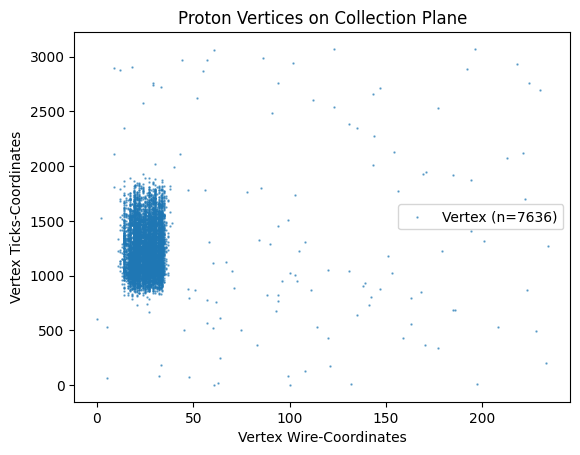

In [37]:
col_wire = np.array(indices['col_wire'].values)
col_time = np.array(indices['col_time'].values)

plt.figure()
plt.scatter(col_wire, col_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Collection Plane')
plt.legend()
plt.show()

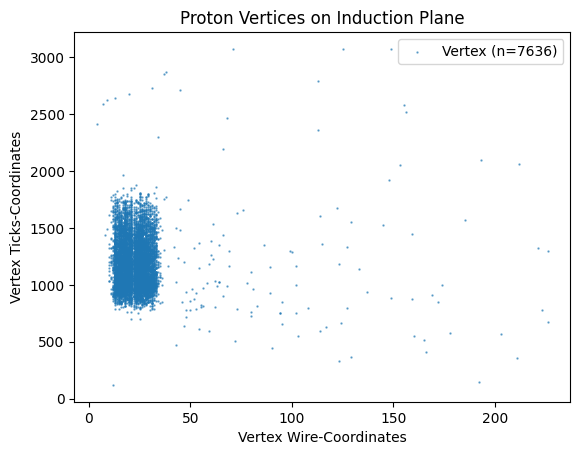

In [38]:
ind_wire = np.array(indices['ind_wire'].values)
ind_time = np.array(indices['ind_time'].values)

plt.figure()
plt.scatter(ind_wire, ind_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Induction Plane')
plt.legend()
plt.show()

In [39]:
# matching time
# threshold improvement
# clustering on clusters, for complex events.
# characterise the jump between ADC for wire before first activity and first activity?

# BOUNDING BOX

Find a region of interest. Search for activity in that region for the deuterons. 

In [40]:
# Removing outliers and finding main cluster bounds

def find_cluster_bounds(wire_coords, time_coords):
    """Find bounds of main cluster using percentiles"""
    # Filter out extreme outliers first
    wire_p5, wire_p95 = np.percentile(wire_coords, [0.3, 98.5]) # visually tuned
    time_p5, time_p95 = np.percentile(time_coords, [0.5, 99.51])
    
    # Mask for main cluster
    mask = ((wire_coords >= wire_p5) & (wire_coords <= wire_p95) & 
            (time_coords >= time_p5) & (time_coords <= time_p95))
    
    # Bounds of main cluster
    wire_min, wire_max = wire_coords[mask].min(), wire_coords[mask].max()
    time_min, time_max = time_coords[mask].min(), time_coords[mask].max()
    
    return wire_min, wire_max, time_min, time_max

cwire_min, cwire_max, ctime_min, ctime_max = find_cluster_bounds(col_wire, col_time)
print(f"Main cluster bounds: Wire [{cwire_min}, {cwire_max}], Time [{ctime_min}, {ctime_max}]")

Main cluster bounds: Wire [12, 37], Time [789, 1927]


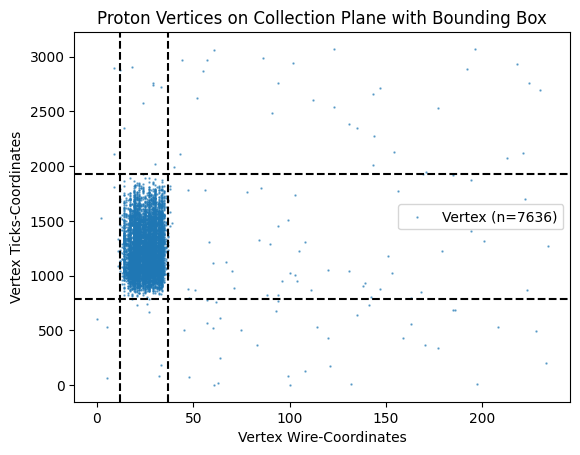

In [56]:
plt.figure()

plt.scatter(col_wire, col_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Collection Plane with Bounding Box')
plt.axhline(y=ctime_min, color='black', linestyle='--')
plt.axhline(y=ctime_max, color='black', linestyle='--')
plt.axvline(x=cwire_min, color='black', linestyle='--')
plt.axvline(x=cwire_max, color='black', linestyle='--')
plt.legend()
plt.show()

In [57]:
# For induction plane

def find_icluster_bounds(wire_coords, time_coords):
    """Find bounds of main cluster using percentiles"""

    wire_p5, wire_p95 = np.percentile(wire_coords, [0.3, 98.2]) # visually tuned (different for induction)
    time_p5, time_p95 = np.percentile(time_coords, [0.5, 99.51])
    

    mask = ((wire_coords >= wire_p5) & (wire_coords <= wire_p95) & 
            (time_coords >= time_p5) & (time_coords <= time_p95))
    
    wire_min, wire_max = wire_coords[mask].min(), wire_coords[mask].max()
    time_min, time_max = time_coords[mask].min(), time_coords[mask].max()
    
    return wire_min, wire_max, time_min, time_max

iwire_min, iwire_max, itime_min, itime_max = find_icluster_bounds(ind_wire, ind_time)
print(f"Main cluster bounds: Wire [{iwire_min}, {iwire_max}], Time [{itime_min}, {itime_max}]")

Main cluster bounds: Wire [11, 35], Time [786, 1794]


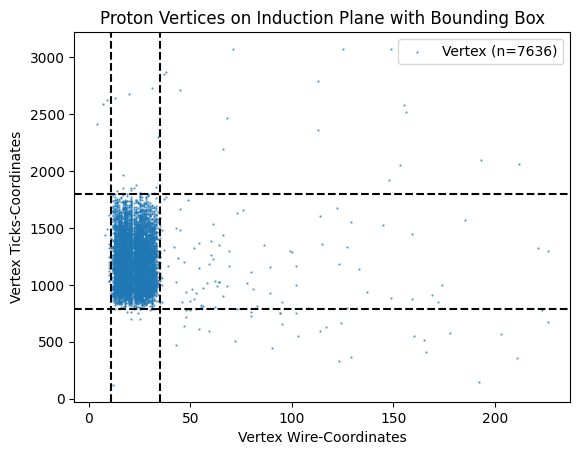

In [58]:
plt.figure()

plt.scatter(ind_wire, ind_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(ind_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Induction Plane with Bounding Box')
plt.axhline(y=itime_min, color='black', linestyle='--')
plt.axhline(y=itime_max, color='black', linestyle='--')
plt.axvline(x=iwire_min, color='black', linestyle='--')
plt.axvline(x=iwire_max, color='black', linestyle='--')
plt.legend()
plt.show()

# DEUTERONS

In [44]:
RAW_DEUTERONS = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root"

DRAW0 = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008560_sr0140_20160529T080009_evtsel_1.root"
DRAW1 = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008590_sr0359_20160528T151336_evtsel_1.root"
DRAW2 = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008557_sr0008_20160529T072623_evtsel_1.root"
DRAW3 = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008557_sr0096_20160529T080513_evtsel_1.root"

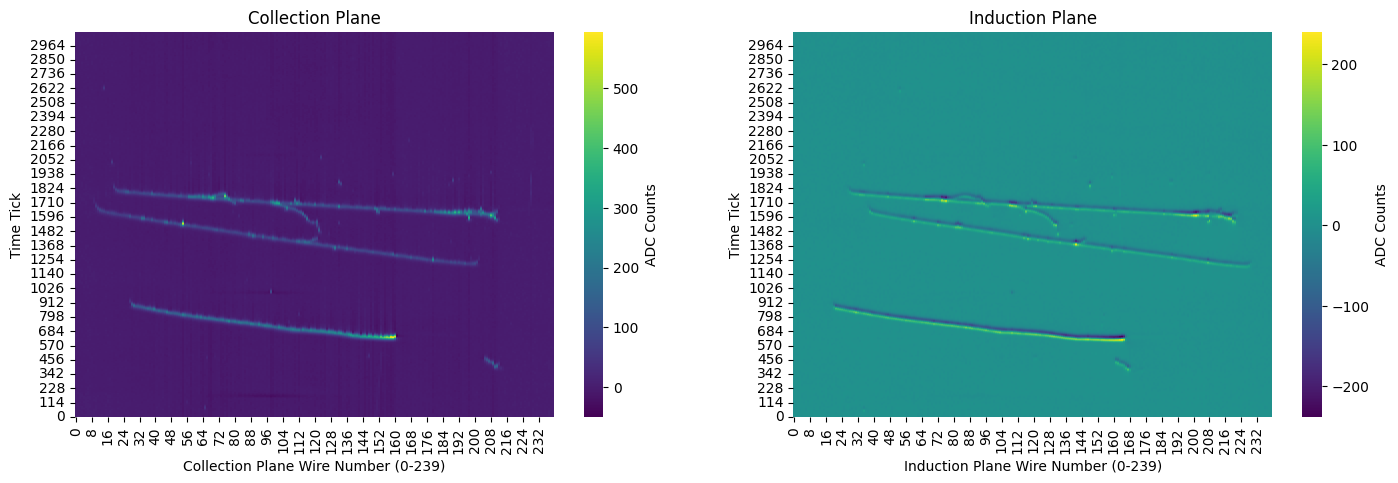

In [45]:
dfile = uproot.open(DRAW3)
dtree = dfile["ana/raw"]

ddata = dtree.arrays(["raw_rawadc", "raw_channel"], library="ak")
dadc_data = ak.to_numpy(ddata[0]["raw_rawadc"])
dchannel_map = ak.to_numpy(ddata[0]["raw_channel"])

dadc_data2d = dadc_data.reshape((num_channels_in_event, num_ticks))

dcollection = np.zeros((240, num_ticks))
dinduction = np.zeros((240, num_ticks))

for i, channel_num in enumerate(dchannel_map):
    if 0 <= channel_num < 240:
        wire_index = channel_num
        dinduction[wire_index, :] = dadc_data2d[i, :]
    if 240 <= channel_num < 480:
        wire_index = channel_num - 240
        dcollection[wire_index, :] = dadc_data2d[i, :]  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))


sns.heatmap(dcollection.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title("Collection Plane")
ax1.invert_yaxis()

sns.heatmap(dinduction.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

In [46]:
def check_activity_in_bbox(filepath, event_index, run, subrun, event, 
                          col_bounds, ind_bounds, threshold=50):
    """
    Simple check for activity within bounding boxes
    
    Args:
        filepath: path to ROOT file
        event_index: index of event in file
        run, subrun, event: event identifiers
        col_bounds: (wire_min, wire_max, time_min, time_max) for collection plane
        ind_bounds: (wire_min, wire_max, time_min, time_max) for induction plane
        threshold: minimum ADC value to consider as activity
    
    Returns:
        dict with event info if activity found, None otherwise
    """
    
    cwire_min, cwire_max, ctime_min, ctime_max = col_bounds
    iwire_min, iwire_max, itime_min, itime_max = ind_bounds
    
    try:
        # Load event data
        file = uproot.open(filepath)
        tree = file["ana/raw"]
        data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
        
        adc_data = ak.to_numpy(data[event_index]["raw_rawadc"])
        channel_map = ak.to_numpy(data[event_index]["raw_channel"])
        
        num_channels_in_event = len(channel_map)
        num_ticks = len(adc_data) // num_channels_in_event
        adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks))
        
        collection = np.zeros((240, num_ticks))
        induction = np.zeros((240, num_ticks))
        
        for i, channel_num in enumerate(channel_map):
            if 0 <= channel_num < 240:
                wire_index = channel_num
                induction[wire_index, :] = adc_data2d[i, :]
            elif 240 <= channel_num < 480:
                wire_index = channel_num - 240
                collection[wire_index, :] = adc_data2d[i, :]
        
        # Check for activity in bounding boxes
        col_roi = collection[cwire_min:cwire_max+1, ctime_min:ctime_max+1]
        ind_roi = induction[iwire_min:iwire_max+1, itime_min:itime_max+1]
        
        col_activity = np.any(col_roi > threshold)
        ind_activity = np.any(ind_roi > threshold // 2) # half the threshold for induction plane
        
        file.close()
        
        # If activity in both planes, record event
        if col_activity and ind_activity:
            return {
                'run': run,
                'subrun': subrun,
                'event': event,
                'file_path': filepath,
                'event_index': event_index,
                'col_max_adc': col_roi.max(),
                'ind_max_adc': ind_roi.max(),
                'col_activity_pixels': np.sum(col_roi > threshold),
                'ind_activity_pixels': np.sum(ind_roi > threshold)
            }
        
    except Exception as e:
        print(f"Error processing {filepath}, event {event_index}: {e}")
        return None
    
    return None

In [47]:
def batch_search_deuterons(deuteron_dir, col_bounds, ind_bounds, threshold=100):
    """
    Search all deuteron files for activity in bounding boxes
    
    Args:
        deuteron_dir: directory containing deuteron ROOT files
        col_bounds: collection plane bounds (wire_min, wire_max, time_min, time_max)
        ind_bounds: induction plane bounds (wire_min, wire_max, time_min, time_max)
        threshold: ADC threshold for activity
    
    Returns:
        DataFrame with events that have activity in both planes
    """
    
    deuteron_path = Path(deuteron_dir)
    root_files = list(deuteron_path.glob("*.root"))
    
    print(f"Searching {len(root_files)} deuteron files...")
    print(f"Collection bounds: Wire [{col_bounds[0]}, {col_bounds[1]}], Time [{col_bounds[2]}, {col_bounds[3]}]")
    print(f"Induction bounds: Wire [{ind_bounds[0]}, {ind_bounds[1]}], Time [{ind_bounds[2]}, {ind_bounds[3]}]")
    print(f"Threshold: {threshold}")
    
    active_events = []
    
    for file_path in tqdm(root_files, desc="Searching files"):
        try:
            # Open file and get event info
            file = uproot.open(file_path)
            tree = file["ana/raw"]
            
            # Get run/subrun/event info for all events in file
            event_data = tree.arrays(["run", "subrun", "event"], library="ak")
            num_events = len(event_data["run"])
            
            # Check each event in the file
            for event_idx in range(num_events):
                run = ak.to_numpy(event_data["run"])[event_idx]
                subrun = ak.to_numpy(event_data["subrun"])[event_idx]
                event = ak.to_numpy(event_data["event"])[event_idx]
                
                result = check_activity_in_bbox(
                    str(file_path), event_idx, run, subrun, event,
                    col_bounds, ind_bounds, threshold
                )
                
                if result:
                    active_events.append(result)
            
            file.close()
            
        except Exception as e:
            print(f"Error processing file {file_path.name}: {e}")
            continue
    
    print(f"\nFound {len(active_events)} events with activity in ROI")
    
    if active_events:
        return pd.DataFrame(active_events)
    else:
        return pd.DataFrame()

In [48]:
# # Use the bounding boxes from your proton analysis
# col_bounds = (cwire_min, cwire_max, ctime_min, ctime_max)
# ind_bounds = (iwire_min, iwire_max, itime_min, itime_max)

# # Search deuteron files
# deuteron_candidates = batch_search_deuterons(RAW_DEUTERONS, col_bounds, ind_bounds, threshold=50)

# # Display results
# if not deuteron_candidates.empty:
#     print(f"\nDeuteron candidates found: {len(deuteron_candidates)}")
#     print(deuteron_candidates.head())
    
#     # Save results
#     deuteron_candidates.to_csv('deuteron_candidates_bbox.csv', index=False)
#     print("\nResults saved to 'deuteron_candidates_bbox.csv'")
# else:
#     print("No deuteron candidates found in the specified region of interest.")

In [59]:
deuteron_candidates = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv')

In [60]:
deuteron_candidates.columns, deuteron_candidates.shape

(Index(['run', 'subrun', 'event', 'file_path', 'event_index', 'col_max_adc',
        'ind_max_adc', 'col_activity_pixels', 'ind_activity_pixels'],
       dtype='object'),
 (6961, 9))

# DEUTERON CANDIDATES AFTER CUT

Event 1/5: Run 9449, Subrun 141, Event 13668


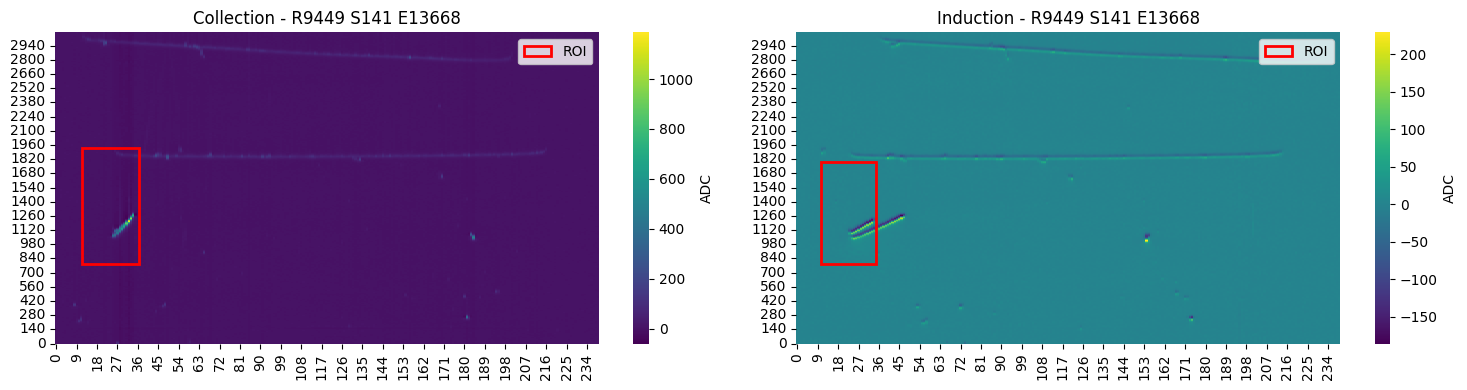

Event 2/5: Run 9451, Subrun 39, Event 3440


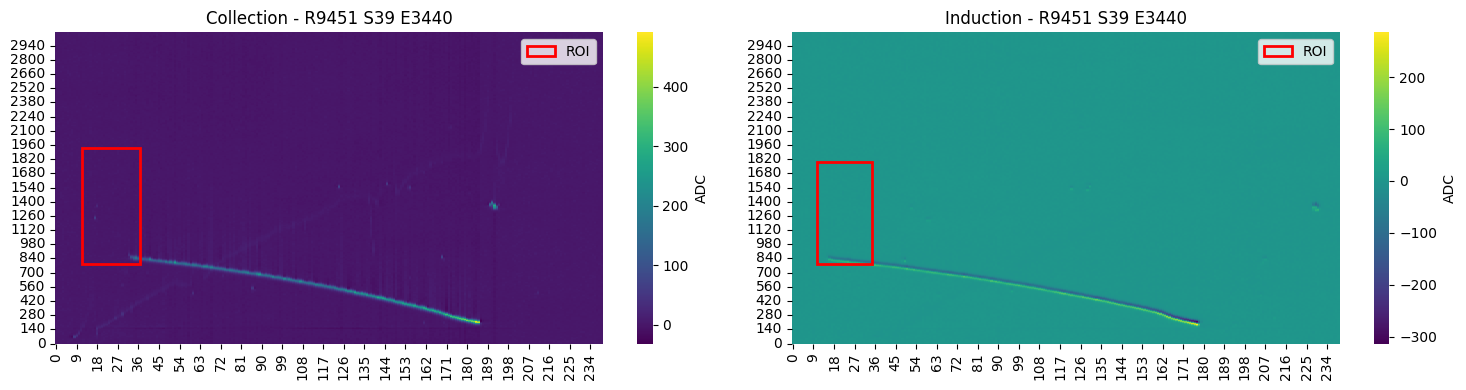

Event 3/5: Run 9783, Subrun 26, Event 3946


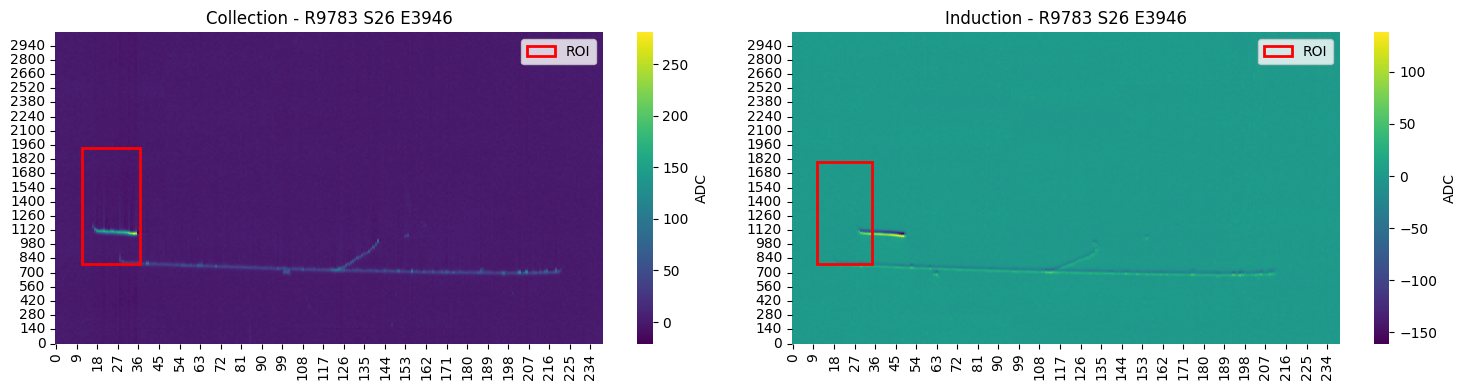

Event 4/5: Run 8652, Subrun 308, Event 24032


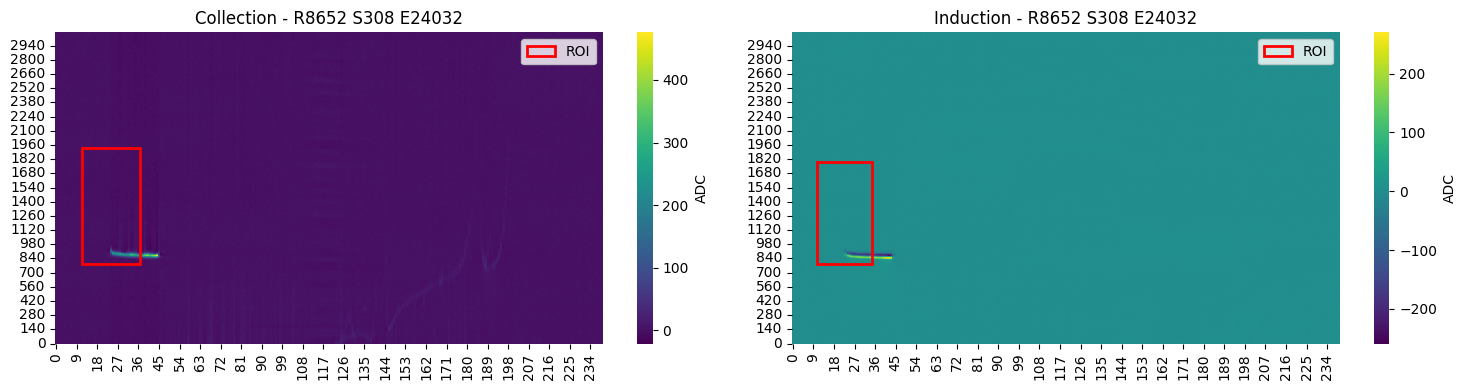

Event 5/5: Run 9542, Subrun 432, Event 30195


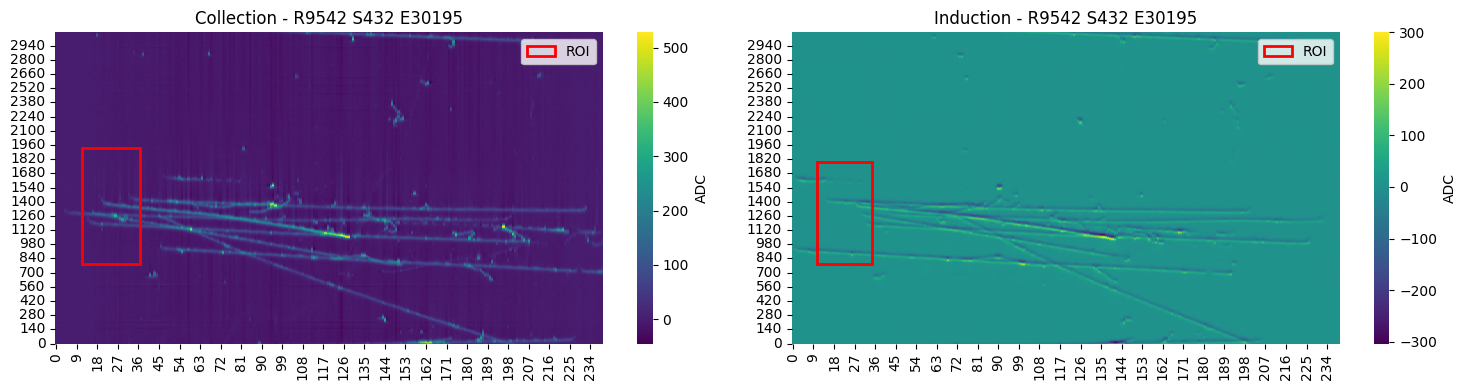

In [51]:
def plot_random_deuteron_candidates(deuteron_candidates, col_bounds, ind_bounds, n_samples=5):
    """Plot random sample of deuteron candidates with ROI boxes"""
    
    if deuteron_candidates.empty:
        print("No deuteron candidates to plot")
        return
    
    # Sample random events
    sample_size = min(n_samples, len(deuteron_candidates))
    sampled = deuteron_candidates.sample(n=sample_size)
    
    cwire_min, cwire_max, ctime_min, ctime_max = col_bounds
    iwire_min, iwire_max, itime_min, itime_max = ind_bounds
    
    for i, (idx, row) in enumerate(sampled.iterrows()):
        print(f"Event {i+1}/{sample_size}: Run {row['run']}, Subrun {row['subrun']}, Event {row['event']}")
        
        try:
            # Load event data
            file = uproot.open(row['file_path'])
            tree = file["ana/raw"]
            data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
            
            adc_data = ak.to_numpy(data[row['event_index']]["raw_rawadc"])
            channel_map = ak.to_numpy(data[row['event_index']]["raw_channel"])
            
            num_channels = len(channel_map)
            num_ticks = len(adc_data) // num_channels
            adc_data2d = adc_data.reshape((num_channels, num_ticks))
            
            # Organize into planes
            collection = np.zeros((240, num_ticks))
            induction = np.zeros((240, num_ticks))
            
            for j, channel_num in enumerate(channel_map):
                if 0 <= channel_num < 240:
                    induction[channel_num, :] = adc_data2d[j, :]
                elif 240 <= channel_num < 480:
                    collection[channel_num - 240, :] = adc_data2d[j, :]
            
            # Plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            
            # Collection plane
            sns.heatmap(collection.T, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC'})
            ax1.add_patch(patches.Rectangle((cwire_min, ctime_min), cwire_max-cwire_min, 
                                          ctime_max-ctime_min, linewidth=2, edgecolor='red', 
                                          facecolor='none', label='ROI'))
            ax1.set_title(f"Collection - R{row['run']} S{row['subrun']} E{row['event']}")
            ax1.legend(loc='upper right')
            ax1.invert_yaxis()
            
            # Induction plane
            sns.heatmap(induction.T, cmap="viridis", ax=ax2, cbar_kws={'label': 'ADC'})
            ax2.add_patch(patches.Rectangle((iwire_min, itime_min), iwire_max-iwire_min, 
                                          itime_max-itime_min, linewidth=2, edgecolor='red', 
                                          facecolor='none', label='ROI'))
            ax2.set_title(f"Induction - R{row['run']} S{row['subrun']} E{row['event']}")
            ax2.legend(loc='upper right')
            ax2.invert_yaxis()
            
            plt.tight_layout()
            plt.show()
            
            file.close()
            
        except Exception as e:
            print(f"Error plotting event {i+1}: {e}")

# Plot random 100 deuteron candidates
col_bounds = (cwire_min, cwire_max, ctime_min, ctime_max)
ind_bounds = (iwire_min, iwire_max, itime_min, itime_max)

plot_random_deuteron_candidates(deuteron_candidates, col_bounds, ind_bounds, n_samples=5)

# Clustering on Deuterons?

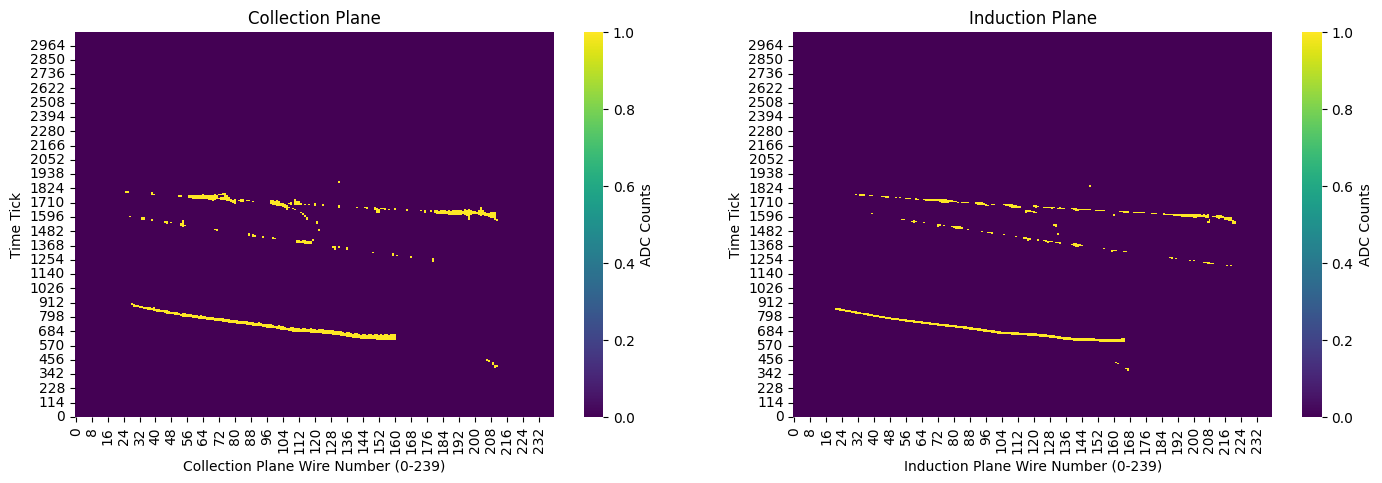

In [52]:
# visualising mask

binary_mask1 = dcollection.T > 100
binary_mask2 = dinduction.T > 50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sns.heatmap(binary_mask1, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title("Collection Plane")
ax1.invert_yaxis()

sns.heatmap(binary_mask2, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

Found 56 connected regions
Region with largest ADC ratio:
  Min ADC: 101.0
  Max ADC: 594.0
  ADC Ratio (max/min): 5.88
  Area: 3756.0 pixels
  Centroid: (723.2, 103.0)
Found 55 connected regions
Region with largest ADC ratio:
  Min ADC: 51.0
  Max ADC: 240.0
  ADC Ratio (max/min): 4.71
  Area: 2870.0 pixels
  Centroid: (699.5, 98.2)


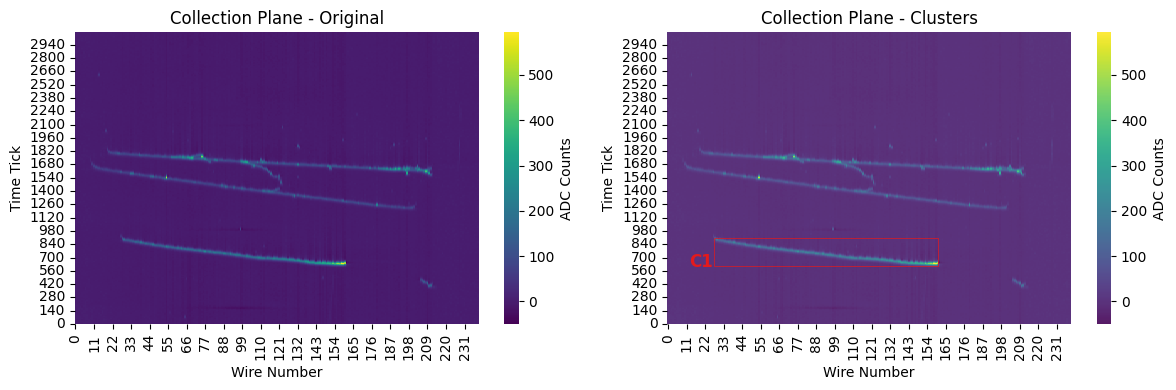

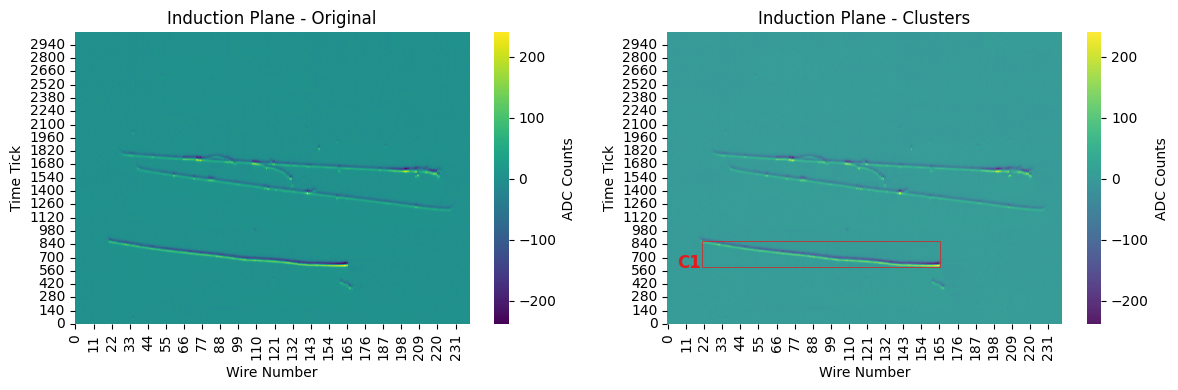

In [53]:
dcol_regions, dcol_props = find_cluster_by_adc_ratio(dcollection.T, threshold=100)
dind_regions, dind_props = find_cluster_by_adc_ratio(dinduction.T, threshold=50)

if dcol_regions is not None and len(dcol_props) > 0:
    visualize_clusters_basic(dcollection.T, dcol_regions, dcol_props, "Collection Plane")

if dind_regions is not None and len(dind_props) > 0:
    visualize_clusters_basic(dinduction.T, dind_regions, dind_props, "Induction Plane")


# another algo idea

1. Find max ADC element (most probably, proton / deuteron)
2. Then find connections > threshold with this element only.


Need to be able to first check whether there's a proton / deuteron in event.

In [54]:
from scipy.ndimage import label as scipy_label
from collections import deque

def find_max_adc_cluster(matrix, threshold=None, connectivity=8, auto_threshold_ratio=5):
    """
    Find cluster starting from maximum ADC element and growing only connected pixels above threshold
    
    Args:
        matrix: 2D array of ADC values
        threshold: minimum ADC value to include in cluster
        connectivity: 4 or 8 for neighbor connectivity
    
    Returns:
        labeled_regions: binary mask of the cluster
        region_props: list containing single region properties
    """
    
    # Find the global maximum ADC position
    max_position = np.unravel_index(np.argmax(matrix), matrix.shape)
    max_adc_value = matrix[max_position]
    
    # Auto-calculate threshold if not provided
    if threshold is None:
        threshold = max_adc_value / auto_threshold_ratio
        print(f"Auto-calculated threshold: {threshold:.1f} (max_adc: {max_adc_value:.1f} / {auto_threshold_ratio})")
    else:
        print(f"Using provided threshold: {threshold:.1f}")

    print(f"Max ADC value: {max_adc_value:.1f} at position {max_position}")
    
    # Check if max ADC is below threshold
    if max_adc_value <= threshold:
        print(f"Max ADC {max_adc_value:.1f} is below threshold {threshold}")
        return None, None
    
    # Create binary mask for pixels above threshold
    above_threshold = matrix > threshold
    
    # Create cluster mask starting from max position
    cluster_mask = np.zeros_like(matrix, dtype=bool)
    visited = np.zeros_like(matrix, dtype=bool)
    
    # BFS/flood fill from max position
    queue = deque([max_position])
    cluster_mask[max_position] = True
    visited[max_position] = True
    
    # Define neighbors based on connectivity
    if connectivity == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    else:  # connectivity == 8
        neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    cluster_pixels = 1
    
    while queue:
        current_pos = queue.popleft()
        
        # Check all neighbors
        for dr, dc in neighbors:
            new_row = current_pos[0] + dr
            new_col = current_pos[1] + dc
            
            # Check bounds
            if (0 <= new_row < matrix.shape[0] and 
                0 <= new_col < matrix.shape[1] and
                not visited[new_row, new_col]):
                
                visited[new_row, new_col] = True
                
                # If neighbor is above threshold, add to cluster
                if above_threshold[new_row, new_col]:
                    cluster_mask[new_row, new_col] = True
                    queue.append((new_row, new_col))
                    cluster_pixels += 1
    
    print(f"Found cluster with {cluster_pixels} pixels starting from max ADC")
    
    # Create region properties manually or use skimage
    if cluster_pixels > 0:
        # Use skimage regionprops for consistency
        labeled_cluster = cluster_mask.astype(int)
        regions = regionprops(labeled_cluster, intensity_image=matrix)
        
        if len(regions) > 0:
            region = regions[0]
            print(f"Cluster properties:")
            print(f"  Area: {region.area} pixels")
            print(f"  Centroid: ({region.centroid[0]:.1f}, {region.centroid[1]:.1f})")
            print(f"  Max intensity: {region.intensity_max:.1f}")
            print(f"  Min intensity: {region.intensity_min:.1f}")
            
            # Total intensity
            total_intensity = matrix[region.coords[:, 0], region.coords[:, 1]].sum()
            print(f"  Total intensity: {total_intensity:.1f}")
            
            return labeled_cluster, [region]
    
    return None, None

def visualize_max_adc_cluster(matrix, labeled_regions, regions, plane_name):
    """Visualize the max ADC cluster with the starting point highlighted"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original heatmap
    sns.heatmap(matrix, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC Counts'})
    ax1.set_title(f"{plane_name} - Original")
    ax1.set_xlabel("Wire Number")
    ax1.set_ylabel("Time Tick")
    
    # Mark max ADC position on original
    max_position = np.unravel_index(np.argmax(matrix), matrix.shape)
    ax1.scatter(max_position[1], max_position[0], c='red', s=100, marker='*', 
               edgecolors='white', linewidth=2, label=f'Max ADC ({matrix[max_position]:.1f})')
    ax1.legend(loc='upper right')
    ax1.invert_yaxis()
    
    # Cluster overlay
    sns.heatmap(matrix, cmap="viridis", ax=ax2, alpha=0.8, cbar_kws={'label': 'ADC Counts'})
    
    if regions and len(regions) > 0:
        region = regions[0]
        coords = region.coords
        
        # Highlight cluster pixels
        ax2.scatter(coords[:, 1], coords[:, 0], c='red', s=2, alpha=0.6, 
                   label=f'Cluster ({region.area} pixels)')
        
        # Mark max ADC position
        ax2.scatter(max_position[1], max_position[0], c='yellow', s=200, marker='*',
                   edgecolors='black', linewidth=2, label=f'Seed Point')
        
        # Bounding box
        minr, minc, maxr, maxc = region.bbox
        rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                               linewidth=2, edgecolor='cyan', facecolor='none',
                               linestyle='--', alpha=0.8)
        ax2.add_patch(rect)
    
    ax2.set_title(f"{plane_name} - Max ADC Cluster")
    ax2.set_xlabel("Wire Number") 
    ax2.set_ylabel("Time Tick")
    ax2.legend(loc='upper right')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

Auto-calculated threshold: 118.8 (max_adc: 594.0 / 5)
Max ADC value: 594.0 at position (np.int64(638), np.int64(158))
Found cluster with 3160 pixels starting from max ADC
Cluster properties:
  Area: 3160.0 pixels
  Centroid: (717.0, 106.2)
  Max intensity: 594.0
  Min intensity: 119.0
  Total intensity: 608507.0
Auto-calculated threshold: 48.0 (max_adc: 240.0 / 5)
Max ADC value: 240.0 at position (np.int64(616), np.int64(164))
Found cluster with 2946 pixels starting from max ADC
Cluster properties:
  Area: 2946.0 pixels
  Centroid: (700.0, 97.9)
  Max intensity: 240.0
  Min intensity: 49.0
  Total intensity: 268252.0


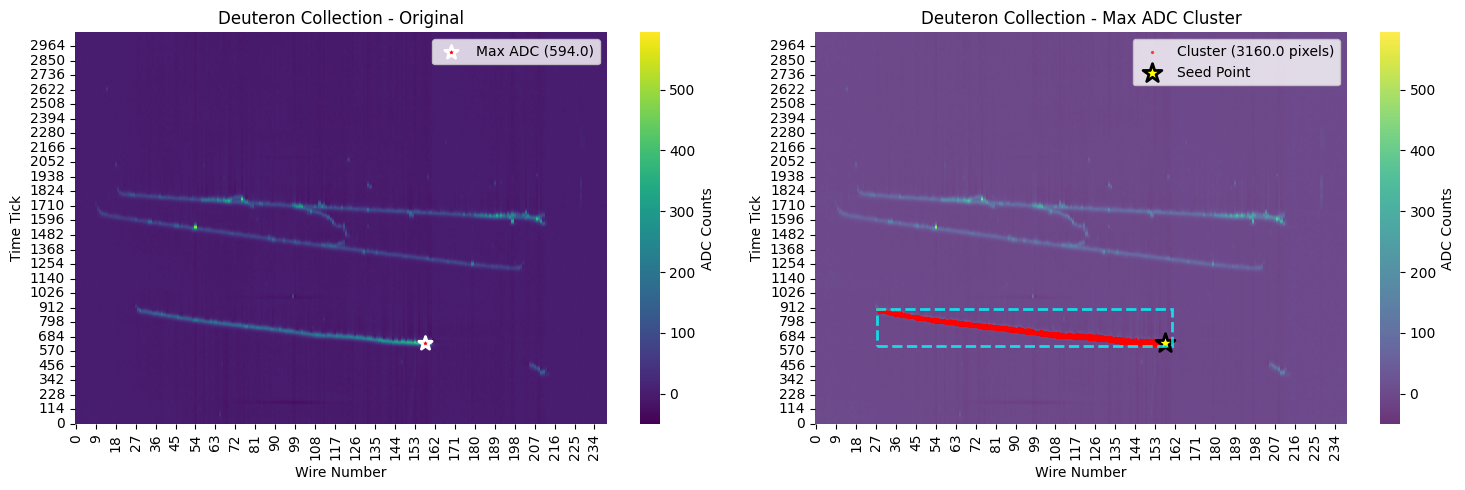

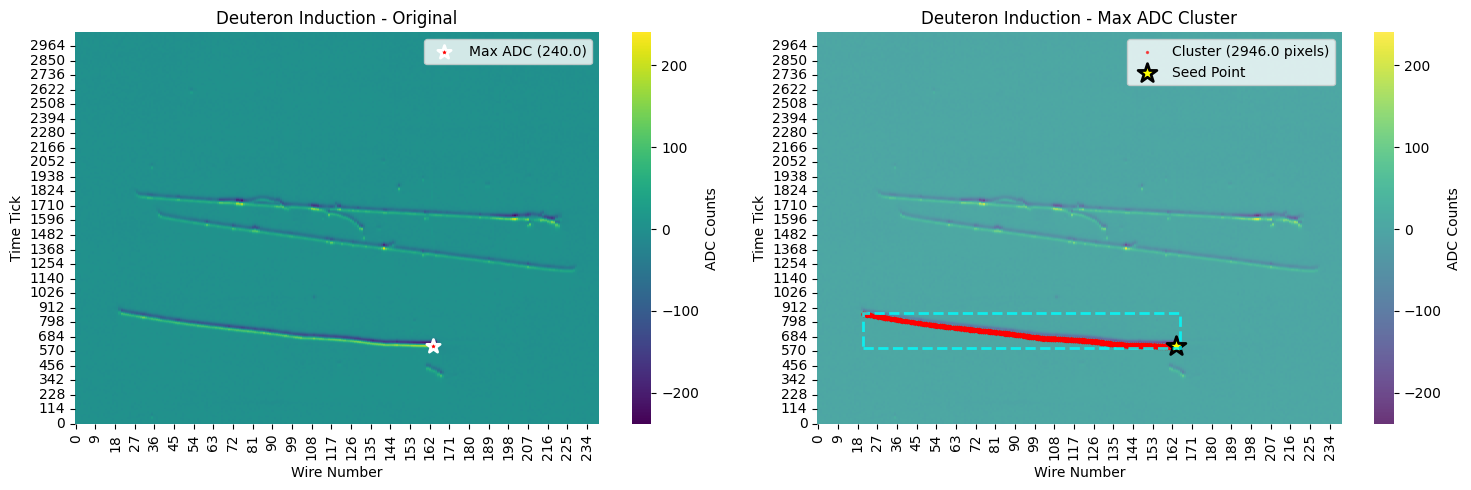

In [55]:

pcol_max_regions, pcol_max_props = find_max_adc_cluster(dcollection.T, threshold=None)

pind_max_regions, pind_max_props = find_max_adc_cluster(dinduction.T, threshold=None)

# Visualize results
if pcol_max_regions is not None:
    visualize_max_adc_cluster(dcollection.T, pcol_max_regions, pcol_max_props, "Deuteron Collection")

if pind_max_regions is not None:
    visualize_max_adc_cluster(dinduction.T, pind_max_regions, pind_max_props, "Deuteron Induction")